# Quantum simulations

## 2 qubits
We first demonstrate how we simulate inner products of 2 2D quantum vectors determined by rotations of angles $\theta_1$ and $\theta_2$ 
\begin{equation}
R_y(\theta_2) | 0\rangle = |v\rangle  \text{ and } R_y(\theta_1) |0\rangle = |c\rangle
\end{equation}


See section 2.1-2.3 in the report also on github.

In [1]:
from qiskit import QuantumCircuit, BasicAer
from qiskit.algorithms import EstimationProblem,FasterAmplitudeEstimation,AmplitudeEstimation
from qiskit.circuit import Parameter
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from numpy import cos, sin
from keras.datasets import mnist
from skimage.util import img_as_ubyte
from skimage.transform import resize
matplotlib.use('Qt5Agg')

In [2]:
backend = BasicAer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend)


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, theta1, theta2):
        super().__init__(2)  # circuit on 2 qubit

        self.h(0)
        self.cry(theta1, 0, 1)
        self.x(0)
        self.cry(theta2, 0, 1)
        self.h(0)
        

class BernoulliA_transpose(QuantumCircuit):
    """A circuit representing the transpose of the Bernoulli A operator."""

    def __init__(self, theta1, theta2):
        super().__init__(2)  # circuit on 2 qubit

        self.h(0)
        self.cry(-theta2, 0, 1)
        self.x(0)
        self.cry(-theta1, 0, 1)
        self.h(0)

class S_0_class(QuantumCircuit):
    def __init__(self):
        super().__init__(2)
        self.x([0,1])
        self.cz([1],0)
        self.x([0,1])
        
    
class neg_S_Psi1_class(QuantumCircuit):
    def __init__(self):
        super().__init__(2)
        self.x(0)
        self.z(0)
        self.x(0)

class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self,theta1, theta2):
        super().__init__(2)  # circuit on 2 qubit
        
        A = BernoulliA(theta1, theta2)
        A_transpose = BernoulliA_transpose(theta1, theta2)
        S_0 = S_0_class()
        neg_S_Psi1 = neg_S_Psi1_class()
        
        
        self.compose(neg_S_Psi1, inplace=True )
        self.compose(A_transpose, inplace=True)
        self.compose(S_0, inplace=True)
        self.compose(A, inplace=True)
        
        

theta1, theta2 = 2*np.pi/6, 0

A = BernoulliA(theta1,theta2)
A.draw(output='mpl')
plt.tight_layout()
plt.title('A operator')
plt.show()

Q = BernoulliQ(theta1,theta2)

Q.draw(output='mpl')
plt.tight_layout()
plt.title('Q operator')
plt.show()

ae = FasterAmplitudeEstimation(
        delta=0.01,
        maxiter=3,
        quantum_instance = quantum_instance,
        rescale=True
)

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    is_good_state=None
)


ae_result = ae.estimate(problem)
print(f'Estimated inner product: {1-ae_result.estimation*2}')
print(f'True inner product: {cos(theta1/2)*cos(theta2/2)+sin(theta1/2)*sin(theta2/2)}')

/Users/simon/opt/anaconda3/envs/tf/lib/python3.8/site-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:194: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


Estimated inner product: 0.8653683625598736
True inner product: 0.8660254037844387


## 4 qubits

Using 4 qubits to store each state vector yields a 16-dimensional inner product. This is demonstrated in the code below.

See section 2.4 in the report.

In [3]:
backend = BasicAer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend)

class BernoulliA_4qb(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, v,c):
        super().__init__(5)  # circuit on 5 qubit
        
        v = v/np.linalg.norm(v,ord=2)
        c = c/np.linalg.norm(c,ord=2)
        
        self.h(0)
        self.state4(v)
        self.x(0)
        self.state4(c)
        self.h(0)
        
    def state2(self,c):
        c = c.reshape((2,2))
        c = c.transpose()
        u,s,vh = np.linalg.svd(c)
        vh = vh.transpose()
        theta = np.arccos(np.clip(s[0],-1,1))
        self.cry(2*theta,0,1)
        self.ccx(0,1,2)
        u_gate = UnitaryGate(u).control(1)
        self.append(u_gate,[0,1])
        vh_gate = UnitaryGate(vh).control(1)
        self.append(vh_gate,[0,2])
        
    def state4(self,v):
        v = v.reshape((4,4))
        v = v.transpose()
        u,s,vh = np.linalg.svd(v)
        vh = vh.transpose()
        self.state2(s)
        self.ccx(0,1,3)
        self.ccx(0,2,4)
        u_gate = UnitaryGate(u).control(1)
        self.append(u_gate,[0,1,2])
        vh_gate = UnitaryGate(vh).control(1)
        self.append(vh_gate,[0,3,4])


class BernoulliA_4qb_computed(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, v,c):
        super().__init__(5)  # circuit on 5 qubit

        A = Operator(BernoulliA_4qb(v,c))
        
        self.append(A,list(range(5)))
        

v = np.random.randint(-10,10,16)
c = np.random.randint(-10,10,16)

norms = np.linalg.norm(v,ord=2)*np.linalg.norm(c,ord=2)
A = BernoulliA_4qb_computed(v,c)
problem = EstimationProblem(
    state_preparation=A,  # A operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    is_good_state=None
)
ae = FasterAmplitudeEstimation(
        delta=0.01,
        maxiter=3,
        quantum_instance = quantum_instance,
        rescale=True
)
ae_result = ae.estimate(problem)
print(f'Estimated inner product: {1-ae_result.estimation*2}')
print(f'True inner product: {np.inner(v,c)/norms}')

Estimated inner product: 0.00441525235206619
True inner product: 0.018921416600189957


# Neural network

Lastly, we demonstrate how to sample inner product estimates from the simulated distribution, and use these to train a neural network on $4\times4$-downscaled mnist images. We first simulate inner products with 1000 uniformly distributed random pairs of vectors. This gives us an estimate of the standard deviation of real quantum inner products. We then train a neural network, and sample each inner products from normal distributions centered around the true inner product valus, and with the estimated standard deviation.

In [4]:
%matplotlib inline

delta_c = 0.5
l=1

backend = BasicAer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend)
ae = FasterAmplitudeEstimation(
        delta=delta_c,
        maxiter=l,
        quantum_instance = quantum_instance,
        rescale=True
)

# Simulate 1000 inner products to estimate the standard deviation.
reps = 1000
errors = 0
for i in range(reps):
    print(f'\rSimulation {i+1}', end='')

    a = np.random.randint(-10,10,16)
    b = np.random.randint(-10,10,16)
    norms = np.linalg.norm(a,ord=2)*np.linalg.norm(b,ord=2)
    A = BernoulliA_4qb_computed(a,b)
    problem = EstimationProblem(
        state_preparation=A,  # A operator
        objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
        is_good_state=None
    )
    ae_result = ae.estimate(problem)
    ip_est = 1-ae_result.estimation*2

    errors+= np.abs(ip_est - np.inner(a,b)/norms)
print('\n')

normalized_std_fun = lambda x: errors/reps


# Function for matrix product with each inner product sampled from normal distributions
def estimate_matrix_prod(a,b):
    n = a.shape[0]
    m = b.shape[1]
    c = np.empty((n,m))
    for i in range(n):
        for j in range(m):
            true_inner_product = np.inner(a[i,:],b[:,j])
            norms = np.linalg.norm(a[i,:],ord=2)*np.linalg.norm(b[:,j],ord=2)
            noise = np.random.normal(loc=0, scale=normalized_std_fun(true_inner_product if norms==0 else true_inner_product/norms))
            c[i,j] = true_inner_product + norms * noise
    return c    



# Load mnist data and downsample to 4 by 4 pixels.

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# np.savez('mnist_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
# data = np.load('mnist_data.npz')
# X_train, y_train, X_test, y_test = data['train_X'], data['train_y'], data['test_X'], data['test_y']


size=4
X_train = img_as_ubyte(resize(X_train, (X_train.shape[0], size, size)))
X_test = img_as_ubyte(resize(X_test, (X_test.shape[0], size, size)))

# Use only images of 3 and 6.
include = [3,6]
train_idx = np.isin(y_train, include)
test_idx = np.isin(y_test, include)

y_train = y_train[train_idx]
X_train = X_train[train_idx]
y_test = y_test[test_idx]
X_test = X_test[test_idx]

n_train = len(y_train)
n_test = len(y_test)

# Show demo images
for i in range(10):
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.show()


# Convert labels to one-hot and normalize inputs
n_classes = len(include)
y_train_oh = np.zeros((n_train, n_classes))
y_test_oh = np.zeros((n_test, n_classes))
for i in range(n_classes):
    y_train_oh[y_train==include[i], i]=1
    y_test_oh[y_test==include[i], i]=1

y_train=y_train_oh
y_test=y_test_oh

X_train = X_train.reshape(-1, size**2)
X_test = X_test.reshape(-1, size**2)

std = X_train.std(axis=0)
mean = X_train.mean(axis=0)
X_train = (X_train-mean)/std
X_test = (X_test-mean)/std
    



# Numpy implementation of neural network
class ffnn():
    def __init__(self, layers, alpha=2, learning_rate=0.01, grad_clip=None, loss=None, activation=None, last_activation=None, metric=None, batch_size=None):
        
        def cross_entropy(y,t):
            L = -np.sum(t*np.log(y + 1e-7))
            dL_da = -t/y + (1-t)/(1-y+1e-7)
            return L, dL_da

        def binary_cross_entropy(y,t):
            L = -np.mean(t * np.log(np.maximum(y , 1e-15)) + (1-t) * np.log(np.maximum(1-y , 1e-15)))
            dL_da = -np.mean(t/np.maximum(y,1e-15) - (1-t)/(np.maximum(1-y , 1e-15)))
            return L, dL_da

        def binary_cross_entropy_sigmoid_logit(y,t):
            L = np.mean(np.maximum(y, 0) - y * t + np.log(1 + np.exp(-np.abs(y))))
            dL_da = sigmoid(y)-t
            return L, dL_da

        def ReLU(z):
            return np.maximum(z,0)

        def ReLU_deriv(z):
            return (z>0).astype(np.float64)

        def sigmoid(z):
            e=np.exp(np.clip(z, -700, 700))
            en=np.exp(-np.clip(z, -700, 700))
            
            return np.where(z<0, e/(1+e), 1/(1+en))

        def sigmoid_deriv(z):
            s = sigmoid(z)
            return s*(1-s)

        def softmax(z):
            e = np.exp(np.clip(z,-700,700)) #prevent overflow
            out = e/np.sum(e,axis=1).reshape(-1,1)
            return out

        def softmax_deriv(z):
            return softmax(z)*(1-softmax(z))

        def linear(z):
            return z

        def linear_deriv(z):
            return 1
            
        def accuracy(true_probs, predicted_probs):
            return np.mean(np.argmax(true_probs,axis=1)==np.argmax(predicted_probs,axis=1))

        def binary_accuracy(true_probs, predicted_probs):
            return np.mean(np.abs(true_probs - predicted_probs)<0.5)


        
        self.layers = layers
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.grad_clip = grad_clip if grad_clip is not None else np.inf
        self.batch_size = batch_size
        self.init_weights()
        
        self.z = [np.inf*np.ones((batch_size, layer)) for layer in layers[1:]]
        self.a = [np.inf*np.ones((batch_size, layer)) for layer in layers]
        self.delta = [np.inf*np.ones((batch_size, layer)) for layer in layers[1:]]
        
        self.act = {'ReLU': ReLU,
                    'sigmoid': sigmoid,
                    'softmax': softmax,
                    'linear': linear}[activation]
        
        self.act_deriv = {'ReLU': ReLU_deriv,
                          'sigmoid': sigmoid_deriv,
                          'softmax': softmax_deriv,
                          'linear': linear_deriv}[activation]
        
        self.last_act = {'ReLU': ReLU,
                         'sigmoid': sigmoid,
                         'softmax': softmax,
                         'linear': linear}[last_activation]
        
        self.last_act_deriv = {'ReLU': ReLU_deriv,
                                'sigmoid': sigmoid_deriv,
                                'softmax': softmax_deriv,
                                'linear': linear_deriv}[last_activation]
        
        self.score_metric = {'accuracy': accuracy,
                             'binary_accuracy': binary_accuracy}[metric]
        
        self.loss = {'cross_entropy': cross_entropy,
                     'binary_cross_entropy': binary_cross_entropy,
                     'binary_cross_entropy_sigmoid_logit': binary_cross_entropy_sigmoid_logit}[loss]
        
        if loss == 'binary_cross_entropy_sigmoid_logit':
            self.pred_last_act = sigmoid
        else:
            self.pred_last_act = self.last_act
        
        
        
    def init_weights(self):
        self.W = []
        self.b = []
        for i in range(1,len(self.layers)):
            std = np.sqrt(2*self.alpha/(self.layers[i-1]+self.layers[i]))
            self.W.append(np.random.normal(loc=0, scale=std, size=(self.layers[i-1],self.layers[i])))
            self.b.append(np.random.normal(loc=0, scale=std, size=self.layers[i]))

    def forward(self, x):
        n = len(self.W)
        self.a[0] = x
    
        for i in range(0,n-1):
            self.z[i] = estimate_matrix_prod(self.a[i],self.W[i]) + self.b[i]
            self.a[i+1] = self.act(self.z[i])
        self.z[-1] = estimate_matrix_prod(self.a[-2],self.W[-1]) + self.b[-1]
        
        y = self.last_act(self.z[-1])

        self.a[-1] = y
        return y

    def backward(self, x, t):
        self.forward(x)
        L, dL_da = self.loss(self.a[-1],t)
        
        n = len(self.W)

        
        self.delta[0] = dL_da * self.last_act_deriv(self.z[-1])
        for i in range(1,n):
            self.delta[i] = estimate_matrix_prod(self.delta[i-1],self.W[n-i].T) * self.act_deriv(self.z[n-i-1])
    
        for i in range(n):
            self.b[i] -= self.learning_rate * np.clip(self.delta[n-i-1], -self.grad_clip, self.grad_clip).mean(axis=0)
            self.W[i] -= self.learning_rate * np.clip(self.delta[n-i-1][:,None] * self.a[i][:,:,None], -self.grad_clip, self.grad_clip).mean(axis=0)
            
        return L
    
    def predict(self, x, t, exact=True):
        n = len(self.W)
        a = x
    
        if exact:
            for i in range(0,n-1):
                z= a@self.W[i] + self.b[i]
                a=self.act(z)
            z = a@self.W[-1] + self.b[-1]
            
        else:
            for i in range(0,n-1):
                z= estimate_matrix_prod(a, self.W[i]) + self.b[i]
                a=self.act(z)
            z = estimate_matrix_prod(a, self.W[-1]) + self.b[-1]
            
        y = self.pred_last_act(z)
        
        score = self.score_metric(t,y)

        return y, score
    
    
    def train(self, X_train, y_train, X_test, y_test, num_epochs, learning_rate_decay=1):
        L = np.zeros(num_epochs)
        scores = []
        nb = X_train.shape[0] - X_train.shape[0]%batch_size
        print(f'omitted {X_train.shape[0]%batch_size} training samples to keep batch size constant.')
        for i in range(0,num_epochs):
            print(f'\rEpoch {i+1}', end='')
            idx = np.random.permutation(nb)
            for j in range(0,nb,self.batch_size):
                X_batch = X_train[idx[j:j+self.batch_size]]
                y_batch = y_train[idx[j:j+self.batch_size]]
                l = self.backward(X_batch,y_batch)
                L[i] += l
                
                
                
            self.learning_rate *= learning_rate_decay
            

            test_preds, score = self.predict(X_test, y_test)
            scores.append(score)
        print('\n')
        return L, np.array(scores)






# Network parameters
alpha=2  # Glorot initialization
batch_size = 102
num_epochs = 10
learning_rate = 0.01
num_hidden = 1
hidden_size = 16
learning_rate_decay=0.97
binary = True  # Whether to use binary (1d) cross entropy or 2d regular cross entropy
# grad_clip = 10  # Gradient clipping


if binary:
    # Remove one-hot encoding
    y_train = y_train[:,0,None]
    y_test = y_test[:,0,None]
    
    # Define neural network
    layers = [X_test.shape[1]]+ [hidden_size]*num_hidden + [y_train.shape[1]]
    model = ffnn(layers, 
                 alpha=alpha, 
                 learning_rate=learning_rate, 
                 loss='binary_cross_entropy_sigmoid_logit',
                 activation='ReLU',
                 last_activation='linear',
                 metric='binary_accuracy',
                 batch_size = batch_size)


else:
    # Define neural network
    layers = [X_test.shape[1]]+ [hidden_size]*num_hidden + [y_train.shape[1]]
    model = ffnn(layers, 
                 alpha=alpha, 
                 learning_rate=learning_rate, 
                 loss='cross_entropy',
                 activation='ReLU',
                 last_activation='softmax',
                 metric='accuracy',
                 batch_size = batch_size)



L,scores = model.train(X_train, y_train, X_test, y_test, num_epochs=num_epochs, learning_rate_decay=learning_rate_decay)



Simulation 1000

omitted 13 training samples
Epoch 10



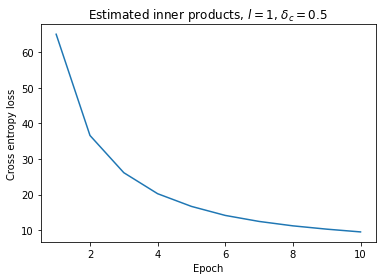

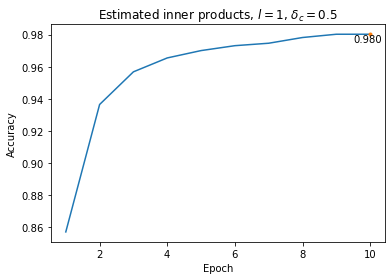

In [7]:
plt.plot(range(1,num_epochs+1),L)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')
plt.title(fr'Estimated inner products, $l={l}$, $\delta_c={delta_c}$')
plt.show()

plt.plot(range(1,num_epochs+1),scores)
plt.text(num_epochs-0.5,scores[-1]*0.995,f'{scores[-1]:.3f}')
plt.plot(num_epochs,scores[-1],'.')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(fr'Estimated inner products, $l={l}$, $\delta_c={delta_c}$')
plt.show()